In [1]:
# !pip install tensorflow-probability nb_black gin-config
# !pip install torch==1.8.0+cpu torchvision==0.9.0+cpu torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
import perturbations

def argmax(x, axis=-1):
    return tf.one_hot(tf.argmax(x, axis=axis), tf.shape(x)[axis])


<IPython.core.display.Javascript object>

In [4]:
argmax(tf.constant([-0.6, 1.9, -0.2, 1.1, -1.0], dtype=tf.float32))

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>

<IPython.core.display.Javascript object>

In [5]:
from perturbations import perturbations

<IPython.core.display.Javascript object>

In [6]:
pert_argmax_fn = perturbations.perturbed(argmax,
                                      num_samples=1000000,
                                      sigma=0.5,
                                      noise='gumbel',
                                      batched=False)


<IPython.core.display.Javascript object>

In [7]:
theta = tf.constant([-0.6, 1.9, -0.2, 1.1, -1.0], dtype=tf.float32)
pert_argmax_fn(theta)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.00546 , 0.815495, 0.01207 , 0.16443 , 0.002545], dtype=float32)>

<IPython.core.display.Javascript object>

In [8]:
sigma = 0.5
tf.nn.softmax(theta / sigma)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.00549293, 0.8152234 , 0.01222475, 0.16459078, 0.00246813],
      dtype=float32)>

<IPython.core.display.Javascript object>

In [9]:
# coding=utf-8
# Copyright 2021 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lint as: python3
"""Tests for the fenchel_young module."""

import tensorflow.compat.v2 as tf

from perturbations import fenchel_young as fy


def ranks(inputs, axis=-1):
    """Returns the ranks of the input values among the given axis."""
    return 1 + tf.cast(
        tf.argsort(tf.argsort(inputs, axis=axis), axis=axis),
        dtype=inputs.dtype,
    )


class FenchelYoungTest(tf.test.TestCase):
    """Testing the gradients obtained by the FenchelYoungLoss class."""

    def test_gradients(self):
        loss_fn = fy.FenchelYoungLoss(
            ranks, num_samples=10000, sigma=0.1, batched=False
        )

        theta = tf.constant([1, 20, 7.3, 7.35])
        y_true = tf.constant([1, 4, 3, 2], dtype=theta.dtype)
        y_hard_minimum = tf.constant([1, 4, 2, 3], dtype=theta.dtype)
        y_perturbed_minimum = tf.constant(loss_fn.perturbed(theta))

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(theta)
            g_true = tape.gradient(loss_fn(y_true, theta), theta)
            g_hard_minimum = tape.gradient(
                loss_fn(y_hard_minimum, theta), theta
            )
            g_perturbed_minimum = tape.gradient(
                loss_fn(y_perturbed_minimum, theta), theta
            )

        # The gradient should be close to zero for the two first values.
        self.assertAllClose(g_true[:2], [0.0, 0.0])
        self.assertLess(tf.norm(g_perturbed_minimum), tf.norm(g_hard_minimum))
        self.assertLess(tf.norm(g_hard_minimum), tf.norm(g_true))
        for g in [g_true, g_hard_minimum, g_perturbed_minimum]:
            self.assertAllClose(tf.math.reduce_sum(g), 0.0)
        print("Good!")

if __name__ == "__main__":
    tf.enable_v2_behavior()
    FenchelYoungTest().test_gradients()


Good!


<IPython.core.display.Javascript object>

In [10]:
from torch.distributions.gumbel import Gumbel
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import numpy as np

<IPython.core.display.Javascript object>

In [11]:
shape = [1000]

<IPython.core.display.Javascript object>

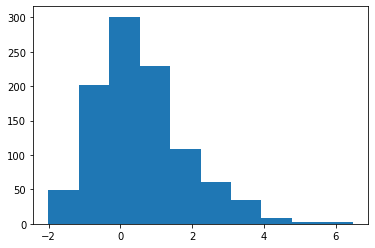

<IPython.core.display.Javascript object>

In [12]:
sampler = Gumbel(0.0, 1.0)
samples_tch = sampler.sample(shape)
plt.hist(samples_tch.numpy(), bins=10)
plt.show()

In [13]:
sampler = tfp.distributions.Gumbel(0.0, 1.0)
samples = sampler.sample(shape)

<IPython.core.display.Javascript object>

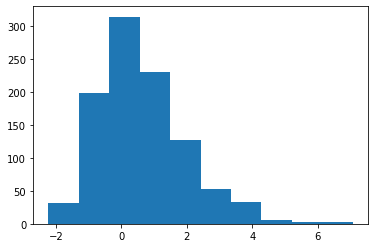

<IPython.core.display.Javascript object>

In [14]:
plt.hist(np.array(samples))
plt.show()

In [39]:
import torch

x = torch.randn([10])
print(x)
x.long().type(torch.randn([1]).dtype)

tensor([-0.1657, -0.3990,  0.2303, -0.1693,  0.1969, -2.2686, -0.5040,  0.0511,
         1.3192,  0.4267])


tensor([ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  1.,  0.])

<IPython.core.display.Javascript object>

In [3]:
import torch
import functools
from typing import Tuple


_GUMBEL = "gumbel"
_NORMAL = "normal"
SUPPORTED_NOISES = (_GUMBEL, _NORMAL)


def sample_noise_with_gradients(noise, shape):
    """Samples a noise tensor according to a distribution with its gradient.

  Args:
   noise: (str) a type of supported noise distribution.
   shape: tf.Tensor<int>, the shape of the tensor to sample.

  Returns:
   A tuple Tensor<float>[shape], Tensor<float>[shape] that corresponds to the
   sampled noise and the gradient of log the underlying probability
   distribution function. For instance, for a gaussian noise (normal), the
   gradient is equal to the noise itself.

  Raises:
   ValueError in case the requested noise distribution is not supported.
   See perturbations.SUPPORTED_NOISES for the list of supported distributions.
  """
    if noise not in SUPPORTED_NOISES:
        raise ValueError(
            "{} noise is not supported. Use one of [{}]".format(
                noise, SUPPORTED_NOISES
            )
        )

    if noise == _GUMBEL:
        sampler = torch.distributions.gumbel.Gumbel(0.0, 1.0)
        samples = sampler.sample(shape)
        gradients = 1 - torch.exp(-samples)
    elif noise == _NORMAL:
        sampler = torch.distributions.normal.Normal(0.0, 1.0)
        samples = sampler.sample(shape)
        gradients = samples

    return samples, gradients


In [14]:
func(input_tensor)

tensor([[1, 0]])

In [43]:
input_tensor = torch.randn([3, 2])
batched = True
num_samples = 300
sigma = 1.
noise = _NORMAL
batched = True
func = lambda x: torch.nn.functional.one_hot(torch.argmax(x, 1), x.shape[1]).type(x.dtype)
# original_input_shape = input_tensor.shape
# if batched:
#     assert len(original_input_shape) >= 2
# else:
#     input_tensor = input_tensor.unsqueeze(0)
# input_shape = input_tensor.shape  # [B, D1, ... Dk], k >= 1
# perturbed_input_shape = [num_samples] + list(input_shape)

# noises = sample_noise_with_gradients(noise, perturbed_input_shape)
# additive_noise, noise_gradient = [noise.type(input_tensor.dtype) for noise in noises]
# perturbed_input = input_tensor.unsqueeze(0) + sigma * additive_noise

# # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
# flat_batch_dim_shape = [-1] + list(input_shape[1:])
# perturbed_input = perturbed_input.view(flat_batch_dim_shape)
# # Calls user-defined function in a perturbation agnostic manner.
# perturbed_output = func(perturbed_input)
# # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
# perturbed_input = perturbed_input.view(perturbed_input_shape)
# # Either
# #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
# # or
# #   (Full-reduce case) [NB] -> [N, B]
# perturbed_output_shape = [num_samples] + [-1] + list(perturbed_output.shape[1:])
# perturbed_output = perturbed_output.view(perturbed_output_shape)

# forward_output = perturbed_output.mean(0)
# if not batched:  # Removes dummy batch dimension.
#     forward_output = forward_output[0]

In [100]:
batched = True
num_samples = 100000
sigma = 0.05
noise = _GUMBEL
batched = True
func = lambda x: torch.nn.functional.one_hot(torch.argmax(x, 1), x.shape[1]).type(x.dtype)

class PerturbedTch(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input_tensor):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        original_input_shape = input_tensor.shape
        orig_shape = torch.LongTensor(list(original_input_shape))
        if batched:
            assert len(original_input_shape) >= 2
        else:
            input_tensor = input_tensor.unsqueeze(0)
        input_shape = input_tensor.shape  # [B, D1, ... Dk], k >= 1
        perturbed_input_shape = [num_samples] + list(input_shape)

        noises = sample_noise_with_gradients(noise, perturbed_input_shape)
        additive_noise, noise_gradient = [noise.type(input_tensor.dtype) for noise in noises]
        perturbed_input = input_tensor.unsqueeze(0) + sigma * additive_noise

        # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
        flat_batch_dim_shape = [-1] + list(input_shape[1:])
        perturbed_input = perturbed_input.view(flat_batch_dim_shape)
        # Calls user-defined function in a perturbation agnostic manner.
        perturbed_output = func(perturbed_input)
        # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
        perturbed_input = perturbed_input.view(perturbed_input_shape)
        # Either
        #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
        # or
        #   (Full-reduce case) [NB] -> [N, B]
        perturbed_output_shape = [num_samples] + [-1] + list(perturbed_output.shape[1:])
        perturbed_output = perturbed_output.view(perturbed_output_shape)
        
        forward_output = perturbed_output.mean(0)
        if not batched:  # Removes dummy batch dimension.
            forward_output = forward_output[0]
        ctx.save_for_backward(orig_shape, noise_gradient, perturbed_output)
        return forward_output
        # ctx.save_for_backward(original_input_shape)
        # return input_tensor.clamp(min=0)

    @staticmethod
    def backward(ctx, dy):
        original_input_shape, noise_gradient, perturbed_output = ctx.saved_tensors
        # perturbed_input_shape = [num_samples] if batched else [num_samples, 1] + list(original_input_shape)
        # perturbed_input_rank = len(perturbed_input_shape)
        perturbed_input_rank = len(original_input_shape) + (1 if batched else 2)

        """Compute the gradient of the expectation via integration by parts."""
        output, noise_grad = perturbed_output, noise_gradient
        # Adds dummy feature/channel dimension internally.
        if perturbed_input_rank > len(output.shape):
            dy = dy.unsqueeze(-1)
            output = output.unsqueeze(-1)
        # Adds dummy batch dimension internally.
        if not batched:
            dy = dy.unsqueeze(0)
        # Flattens [D1, ..., Dk] to a single feat dim [D].
        flatten = lambda t: t.view(t.shape[0], t.shape[1], -1)
        dy = dy.view(dy.shape[0], -1)  # (B, D)
        output = flatten(output)  # (N, B, D)
        noise_grad = flatten(noise_grad)  # (N, B, D)

        g = torch.einsum(
            "nbd,nb->bd",
            noise_grad,
            torch.einsum("nbd,bd->nb", output, dy),
        )
        g /= sigma * num_samples
        return g.view(*original_input_shape)

input_tensor = torch.randn([3, 2])
input_tensor.requires_grad = True
out = PerturbedTch.apply(input_tensor)
out

tensor([[1.0000e+00, 0.0000e+00],
        [9.9998e-01, 2.0000e-05],
        [0.0000e+00, 1.0000e+00]], grad_fn=<PerturbedTchBackward>)

In [101]:
loss = out.mean()

In [102]:
loss.backward()

In [103]:
input_tensor.grad

tensor([[-0.0183, -0.0135],
        [-0.0087,  0.0170],
        [-0.0156,  0.0078]])

In [104]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from perturbations.fenchel_young_tch import FenchelYoungLoss

def ranks(inputs, dim=-1):
    """Returns the ranks of the input values among the given axis."""
    return 1 + inputs.argsort(dim).argsort(dim).type(inputs.dtype)

x = torch.randn([3, 5]).float().unsqueeze(0)
print(x)
x.requires_grad = True
y_true = torch.arange(5).float().unsqueeze(0).repeat([x.shape[0], 1])

tensor([[[-0.8010,  1.2944,  0.4856,  0.6414,  0.1016],
         [-0.1898,  0.3584,  0.4202, -0.8507, -0.2613],
         [ 1.1522, -1.0642,  1.1020,  0.9677,  0.4820]]])


In [3]:
optim = torch.optim.SGD([x], 0.01)

In [96]:
optim.zero_grad()
criterion = FenchelYoungLoss(ranks)
loss = criterion(y_true, x).sum()
loss.backward()
optim.step()
x

tensor([[[-1.7310, -0.3490, -0.3152, -0.2833, -0.2496],
         [-1.3052, -1.0426, -1.0086, -0.9748, -0.8419],
         [-0.9017, -1.0642, -0.0498, -0.0148,  0.0202]]], requires_grad=True)

In [6]:
f = criterion.perturbed(x)
print(f)

None
